# Anuario de Aforos: seleccionar estaciones
***

***Autor:** Jesús Casado Rodríguez*<br>
***Fecha:** 22-03-2025*<br>

**Introducción:**<br>
En este _notebook_ se analizan los datos del *Anuario de Aforos* y se hace una selección de las estaciones a incluir en CAMELS-ES en base a:

1. Disponibilidad mínima de datos en la serie de caudal.
2. Series de caudal con mínima alteración del régimen natural, puesto que las series claramente influidas por embalses no son propicias para el modelado.
3. Eliminar estaciones que por cercanía están altamente correlacionadas.

**Por hacer**:


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cf
from tqdm.notebook import tqdm

from anuario_aforos import *
from config import Config

## Configuración

In [2]:
cfg = Config('../config.yml')

```Python
with open("../config.yml", "r", encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

# rutas de entrada y salida de datos
path_in = Path(cfg['rutas']['anuario_aforos']['orig'])
path_out = Path(cfg['rutas']['anuario_aforos'].get('repo', '../../data/anuario_aforos'))
path_GIS = path_out / 'GIS'
path_plots = path_out / 'plots'
for path in [path_out, path_GIS, path_plots]:
    if path.exists() is False:
        path.mkdir()

# inicio y fin del periodo de estudio
cfg_camels = cfg['CAMELS-ES']
start = cfg_camels['periodo'].get('inicio', None)
end = cfg_camels['periodo'].get('final', None)
start, end = [pd.to_datetime(i) for i in [start, end]]

# tamaño mínimo y máximo de la cuenca
area_min = cfg_camels['area'].get('min', 100) # km²
area_max = cfg_camels['area'].get('max', None) # km²

# disponibilidad mínima de datos durante el periodo de estudio (tanto por uno)
disponibilidad = cfg_camels['caudal'].get('disponibilidad', .8)
min_años = cfg_camels['caudal'].get('n_años', 10)

# sistema de coordenadas
crs = cfg.get('crs', 4326)
```

## Estaciones

In [3]:
cuencas = {dir.stem: dir for dir in cfg.path_in.iterdir() if dir.is_dir()}
if 'estaciones' in locals():
    del estaciones
for cuenca, folder in cuencas.items():
    stns = extraer_estaciones(
        folder / 'estaf.csv',
        min_area=cfg.area_min, 
        max_area=cfg.area_max, 
        years=cfg.min_años, 
        epsg=cfg.crs)
    stns['cuenca'] = cuenca
    if 'estaciones' in locals():
        estaciones = pd.concat((estaciones, stns))
    else:
        estaciones = stns
    print('nº de estaciones en el {0:>12}:\t\t{1}'.format(cuenca.capitalize(), stns.shape[0]))

nº de estaciones en el        Duero:		187
nº de estaciones en el   Cantabrico:		67
nº de estaciones en el         Ebro:		254
nº de estaciones en el       Segura:		62
nº de estaciones en el        Jucar:		105
nº de estaciones en el Guadalquivir:		105
nº de estaciones en el     Miño-sil:		71
nº de estaciones en el         Tajo:		181
nº de estaciones en el     Guadiana:		124
nº de estaciones en el Galicia costa:		44


nº total de estaciones:		1200
nº de estaciones en servicio:	795


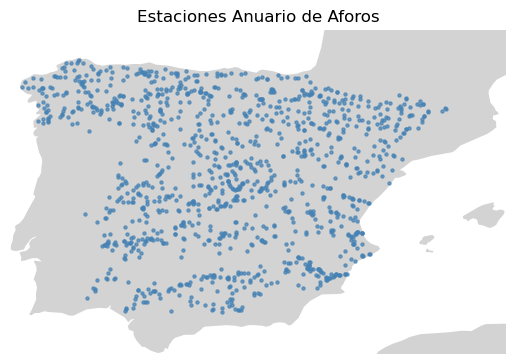

In [4]:
# plot estaciones
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj})
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
ax.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
ax.scatter(estaciones.geometry.x, estaciones.geometry.y, c='steelblue', s=5, alpha=.7, label='Anuario')
ax.set_title('Estaciones Anuario de Aforos')
ax.axis('off');

plt.savefig(cfg.path_plots / 'estaciones.jpg', dpi=300, bbox_inches='tight');

print('nº total de estaciones:\t\t{0}'.format(estaciones.shape[0]))
print('nº de estaciones en servicio:\t{0}'.format(estaciones.loc[estaciones.serv == 1].shape[0]))

In [8]:
# sns.histplot(estaciones.naa, binwidth=1);

In [7]:
# sns.histplot(estaciones.suprest);
# plt.xscale('log')

## Embalses

In [5]:
if 'embalses' in locals():
    del embalses
for cuenca in tqdm(cuencas):
    res = extraer_embalses(cfg.path_in / cuenca / 'embalse.csv', epsg=cfg.crs)
    res['cuenca'] = cuenca
    if 'embalses' in locals():
        embalses = pd.concat((embalses, res))
    else:
        embalses = res
    print('nº de embalses en el {0:>12}:\t\t{1}'.format(cuenca.capitalize(), res.shape[0]))
    del res

  0%|          | 0/10 [00:00<?, ?it/s]

nº de embalses en el        Duero:		31
nº de embalses en el   Cantabrico:		22
nº de embalses en el         Ebro:		95
nº de embalses en el       Segura:		18
nº de embalses en el        Jucar:		35
nº de embalses en el Guadalquivir:		62
nº de embalses en el     Miño-sil:		35
nº de embalses en el         Tajo:		57
nº de embalses en el     Guadiana:		35
nº de embalses en el Galicia costa:		8


nº total de embalses:		398
nº de embalses en servicio:	367


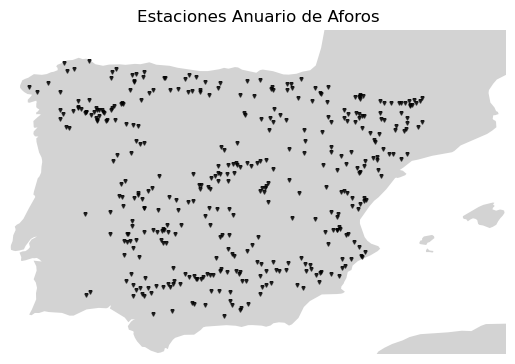

In [6]:
# plot subcuencas
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj})
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
ax.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
ax.scatter(embalses.geometry.x, embalses.geometry.y, c='k', marker='v', s=5, alpha=.7, label='Anuario')
ax.set_title('Estaciones Anuario de Aforos')
ax.axis('off');

plt.savefig(cfg.path_plots / 'embalses.jpg', dpi=300, bbox_inches='tight');

print('nº total de embalses:\t\t{0}'.format(embalses.shape[0]))
print('nº de embalses en servicio:\t{0}'.format(embalses.loc[embalses.serv == 1].shape[0]))

## Caudal 

In [7]:
if 'caudal' in locals():
    del caudal
for cuenca in tqdm(cuencas):
    ids = estaciones[estaciones.cuenca == cuenca].index.to_list()
    q = extraer_caudal_estaciones(cfg.path_in / cuenca / 'afliq.csv', indroea=ids, start=cfg.start, end=cfg.end)
    if 'caudal' in locals():
        caudal = pd.concat((caudal, q), axis=1)
    else:
        caudal = q
    print('nº de estaciones en las series de caudal del {0:>12}:\t\t{1} ({2})'.format(cuenca.capitalize(),
                                                                                  q.shape[1],
                                                                                  len(ids)))

print('nº total de estaciones con serie de caudal:\t\t{0} ({1})'.format(caudal.shape[1], estaciones.shape[0]))

  0%|          | 0/10 [00:00<?, ?it/s]

nº de estaciones en las series de caudal del        Duero:		178 (187)
nº de estaciones en las series de caudal del   Cantabrico:		55 (67)
nº de estaciones en las series de caudal del         Ebro:		224 (254)
nº de estaciones en las series de caudal del       Segura:		41 (62)
nº de estaciones en las series de caudal del        Jucar:		53 (105)
nº de estaciones en las series de caudal del Guadalquivir:		84 (105)
nº de estaciones en las series de caudal del     Miño-sil:		58 (71)
nº de estaciones en las series de caudal del         Tajo:		121 (181)
nº de estaciones en las series de caudal del     Guadiana:		86 (124)
nº de estaciones en las series de caudal del Galicia costa:		40 (44)
nº total de estaciones con serie de caudal:		940 (1200)


In [8]:
# añadir un campo booleano en 'estaciones' si tiene o no datos de caudal
estaciones['caudal'] = 0
estaciones.loc[caudal.columns, 'caudal'] = 1

In [12]:
# definir el mejor periodo de estudio de cada estación
estaciones[['inicio', 'fin']] = periodo_estudio(caudal, cfg.disponibilidad, cfg.min_años)

# estaciones con el mínimo de nº de años
mask_años = ~estaciones.inicio.isnull()
print('nº total de estaciones con {0} años de caudal:\t\t{1}'.format(cfg.min_años, mask_años.sum()))#caudal.shape[1]))

nº total de estaciones con 8 años de caudal:		721


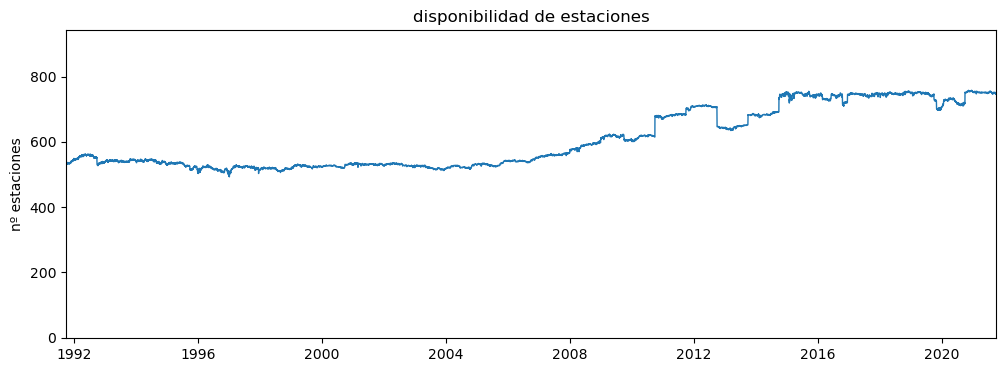

In [15]:
# gráfico de la disponibilidad de estaciones
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(caudal.shape[1] - caudal.isnull().sum(axis=1), lw=1)
ax.set(
    ylim=(-2, caudal.shape[1] + 2),
      xlim=(cfg.start, cfg.end), 
      ylabel='nº estaciones'
      )
ax.axhline(estaciones.shape[0], c='k', lw=.5)
ax.set_title('disponibilidad de estaciones');

plt.savefig(cfg.path_plots / 'disponibilidad.jpg', dpi=300, bbox_inches='tight');

In [19]:
# hidrogramas de cada estación
plt.switch_backend('Agg')
for stn in tqdm(estaciones[mask_años].index):
    
    # inicio y fin de la serie de esta estación
    inicio = datetime(int(estaciones.loc[stn, 'inicio']), 1, 1)
    fin = datetime(int(estaciones.loc[stn, 'fin']), 1, 1)

    # hidrogromas
    path = cfg.path_out / estaciones.loc[stn, 'cuenca'] / 'plots' 
    path.mkdir(parents=True, exist_ok=True)
    file = path / f'{stn:04}.jpg'
    title = '{0} - {1} ({2} km2)'.format(stn, *estaciones.loc[stn, ['lugar', 'suprest']])
    plot_caudal(caudal.loc[inicio:fin, stn], title=title, save=file)

  0%|          | 0/721 [00:00<?, ?it/s]

In [24]:
# estaciones a eliminar porque la serie está alterada por embalses
# las estaciones comentadas son etaciones dudosas
eliminar = {'CANTABRICO': ['1164','1175', '1186', '1196', '1207', '1215', '1237',
                           '1264', '1274', '1276', '1294', '1335', '1358', '1359',
                           '1425', '1446', '1588', '1805'],
            'DUERO': ['2001', '2002', '2004', '2010', '2011', '2018', '2019', '2020',
                      '2021', '2023', '2024', '2032', '2040', '2042', '2044', '2048', '2052', '2066',
                      '2073', '2075', '2078', '2084', '2087', '2088', '2091', '2094',
                      '2099', '2102', '2103', '2108', '2109', '2111', '2112', '2124', '2129',
                      '2133', '2134', '2135', '2137', '2140', '2148', '2149', '2161',
                      '2162', '2718', '2719'],
            #'2041', '2050', '2061', '2062', '2074'
            'EBRO': ['9001', '9005', '9007', '9008', '9010', '9012', '9013', '9014',
                     '9015', '9017', '9022', '9024', '9025', '9026', '9027', '9031',
                     '9032', '9034', '9035', '9036', '9042', '9047', '9048', '9049',
                     '9055', '9056', '9057', '9058', '9059', '9060', '9065', '9066', '9076', '9083',
                     '9084', '9087', '9094', '9096', '9097', '9099', '9100', '9101', '9105',
                     '9106', '9111', '9115', '9118', '9122', '9123', '9124', '9125',
                     '9126', '9127', '9137', '9142', '9145', '9147', '9155', '9161',
                     '9163', '9168', '9174', '9176', '9185', '9186', '9190', '9191', '9192',
                     '9193', '9201', '9209', '9216', '9225', '9229', '9230', '9231', '9250', '9250',
                     '9251', '9255', '9258', '9260', '9264', '9266', '9273', '9277', '9278', '9290',
                     '9292', '9307', '9315', '9319'],
            #, '9153', '9291', '9317'
            'GALICIA COSTA': ['1455', '1514', '1519', '1550', '1564'],
            'GUADALQUIVIR': ['5001', '5004', '5014', '5019', '5020', '5024', '5025',
                             '5027', '5041', '5042', '5048', '5077', '5081', '5082', '5084', '5090',
                             '5095', '5127', '5140', '5147', '5144', '5150'],
             # '5045', '5050', '5138', '5140', ''
            'GUADIANA': ['4004', '4009', '4013', '4030', '4105', '4201', '4202', '4203', '4207', '4209',
                         '4212', '4214', '4904'],
            # , ''
            'JUCAR': ['8005', '8015', '8022', '8025', '8027', '8032', '8036', '8042', '8071', '8074', '8089',
                      '8092', '8093', '8096', '8107', '8112', '8119', '8129', '8130', '8137', '8138', '8139',
                      '8140', '8144', '8145', '8147', '8148', '8153'],
                      #, '8028', '8032', '8060', '8104', '8120'
            'MIÑO-SIL': ['1631', '1639', '1640', '1642', '1719', '1831'],
            'SEGURA': ['7001', '7003', '7004', '7006', '7013', '7016', '7018', '7029', '7030', '7055',
                       '7057', '7062', '7063', '7064', '7112', '7121', '7124', '7137', '7164', '7167', '7628'],
            # , '7112', '7117', '7121', '7165', ''
            'TAJO': ['3003', '3031', '3041', '3048', '3054', '3060', '3061', '3063', '3067', '3070', '3080',
                     '3082', '3147', '3149', '3153', '3158', '3162', '3164', '3172', '3173', '3177', '3183',
                     '3187', '3188', '3230', '3232', '3233', '3237', '3238', '3240', '3243', '3248',
                     '3251', '3254', '3255', '3258', '3259', '3270', '3271', '3273', '3281', '3904',
                      '3940'],
            #'3012', '3014', '3062, '3169', '3174', '3175', '3220', '3233', 
            #'3250', '3251', '3253', '3255', '3256', '3268', '3276', '3278', '3279', ''
            }

In [25]:
# crear campo booleano con las estaciones seleccionadas
estaciones['sel'] = (~estaciones.inicio.isnull()).astype(int)
for cuenca in cuencas:
    estaciones.loc[eliminar[cuenca], 'sel'] = 0

print('nº de estaciones seleccionadas:\t{0}'.format((estaciones.sel == 1).sum()))

nº de estaciones seleccionadas:	428


In [28]:
# estaciones a eliminar porque hay otra estación cercana
eliminar2 = {'CANTABRICO': ['1303'],
            'DUERO': ['2076', '2070', '2068', '2117', '2710', '2123', '2097', '2085', ],
            'EBRO': ['9153', '9046', '9091', '9043', '9268', '9018', '9313', '9253', '9329', '9050'],
            'GALICIA COSTA': ['1440', '1483'],
            'GUADALQUIVIR': ['5076', '5128', '5080'],
            'GUADIANA': [],
            'JUCAR': ['8030'],
            'MIÑO-SIL': ['1644', '1645','1626', '1625', '1628', '1621', '1607', '1608', '1617', '1754',
                      '1727', '1722', '1724'],
            'SEGURA': ['7165', '7117', '7129'],
            'TAJO': ['3194', '3102', '3159'],
            }

In [29]:
for cuenca in cuencas:
    estaciones.loc[eliminar2[cuenca], 'sel'] = 0

print('nº de estaciones seleccionadas:\t{0}'.format((estaciones.sel == 1).sum()))

nº de estaciones seleccionadas:	384


## Exportar resultados

In [31]:
# exportar todas las estaciones juntas
estaciones.to_file(cfg.path_GIS / 'estaciones.shp', driver='ESRI Shapefile', index=True)

# exportar las series de caudal
caudal.to_parquet(cfg.path_out / 'caudal.parquet')

# exportar todos los embalses juntos
embalses.rename(columns={'nom_embalse': 'nombre'}, inplace=True)
embalses.to_file(cfg.path_GIS / 'embalses.shp', driver='ESRI Shapefile', index=True)